# **Malaria Detection Using Machine learning: SVM**

Team: Malar-ai.netlify.app

Biomedical Engineering
Addis Ababa Institute of Technology
Addis Ababa University

In [ ]:
!pip install opendatasets
!pip install -q kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abrahamgenetu","key":"0da3b16e3c3e59eb21cfb2b295b55b38"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 69 Jun 20 11:25 kaggle.json


In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s malaria

ref                                                 title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
imdevskp/malaria-dataset                            Malaria Dataset                                      52KB  2020-07-01 17:28:22           5717         88  1.0              
iarunava/cell-images-for-detecting-malaria          Malaria Cell Images Dataset                         675MB  2018-12-05 05:40:21          44246       1189  0.625            
kmader/malaria-bounding-boxes                       Malaria Bounding Boxes                                4GB  2019-05-09 13:37:54           3518        118  0.75             
miracle9to9/files1                                  Malaria Dataset                                     525MB  2020-01-0

In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

100% 675M/675M [00:33<00:00, 23.0MB/s]
100% 675M/675M [00:33<00:00, 21.2MB/s]


In [ ]:
!unzip /content/cell-images-for-detecting-malaria.zip


Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_i

In [ ]:
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

from ipywidgets import IntProgress
from IPython.display import display
from os import listdir, path
from math import floor
import numpy as np
import random

# set random seeds to aid reproducibility
random.seed(22)
np.random.seed(22)

from skimage import io, color
from skimage.transform import resize

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import svm, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold



# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

## Image Preprocessing stage

In [ ]:
malaria_dataset_path = '/content/cell_images'
parasitized_dir = 'Parasitized'
uninfected_dir = 'Uninfected'
default_ext = '.npy'

def initialize_progress_bar(max_count):
    '''
        Initializes a progress bar with range from
        0 to max_count and returns it.

        By setting the value of the progress bar
        returned one can visualise the progress of
        lengthy processes.
    '''

    f = IntProgress(min=0, max=max_count)
    display(f)
    f.value = 0
    return f

def save_data(data, save_file_path, data_type='float32'):
    '''
        Convert the contents of the numpy array specified
        in data to the data type specified in data_type,
        by default float32, and then save to disk in the
        path specified in save_file_path.
    '''

    print('Saving file {0}...'.format(save_file_path))
    data = data.astype(data_type)
    np.save(save_file_path, data, allow_pickle=False, fix_imports=False)
    print('Done.')
    return data

def load_data(file_path):
    '''
        Load a numpy array from the file located at
        file_path and return it.
    '''

    data = np.load(file_path)
    return data

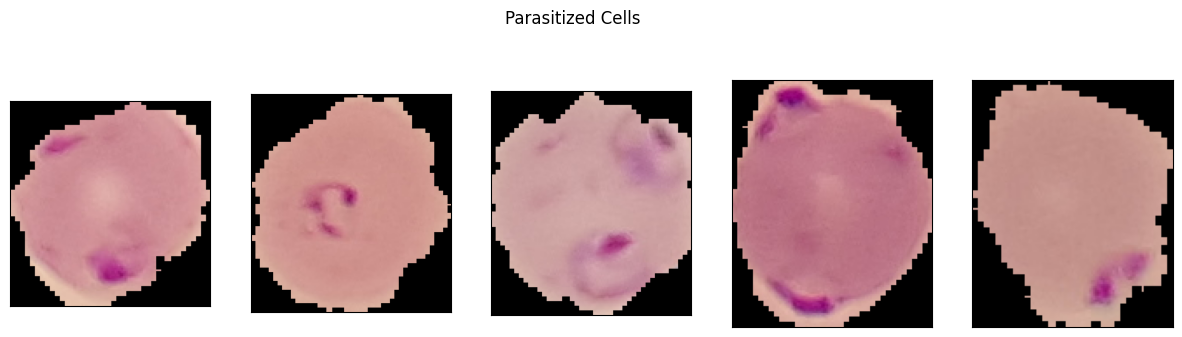

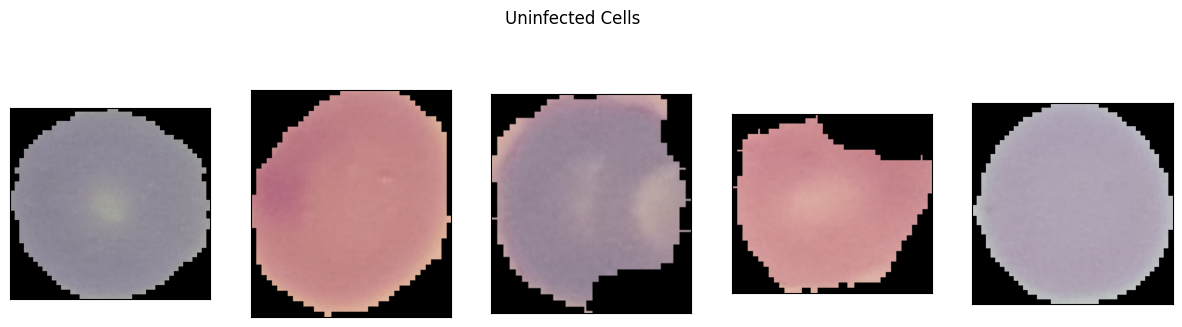

In [ ]:
def show_sample_cells(cell_type, num_cells=5, greyscale=False, resize_image=False):
    fig, axes = plt.subplots(1, num_cells, figsize=(15,4))
    fig.suptitle('{0} Cells{1}{2}'.format(cell_type,
                                          ' - Greyscale' if greyscale else '',
                                          ' - 50x50' if resize_image else ''))
    for idx, f in enumerate(listdir(path.join(malaria_dataset_path, cell_type))[:5]):
        cell_image = io.imread(path.join(malaria_dataset_path, cell_type, f))
        if resize_image:
            cell_image = resize(cell_image, (50, 50, cell_image.shape[2]), mode='reflect')
        if greyscale:
            cell_image = color.rgb2gray(cell_image)
            axes[idx].imshow(cell_image, cmap='gray')
        else:
            axes[idx].imshow(cell_image)
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])

show_sample_cells(parasitized_dir)


show_sample_cells(uninfected_dir)



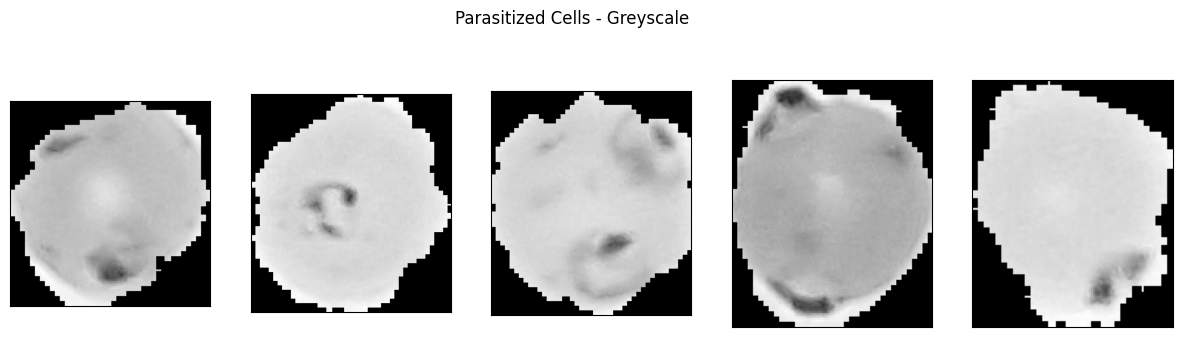

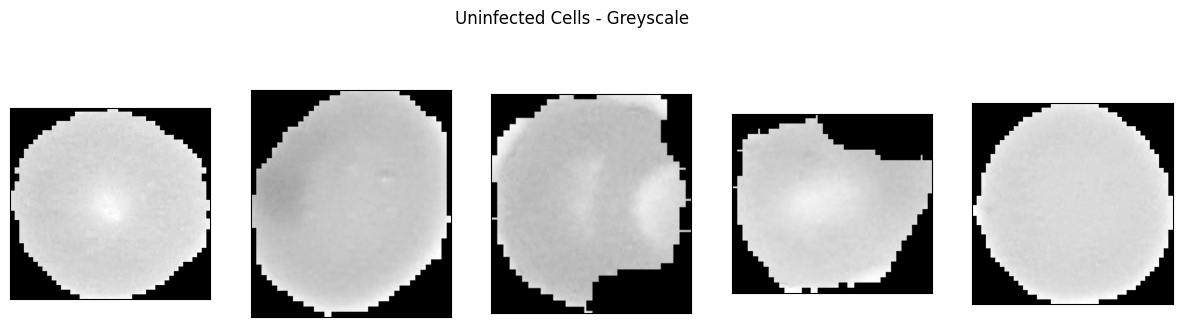

In [ ]:
show_sample_cells(parasitized_dir, greyscale=True)

show_sample_cells(uninfected_dir, greyscale=True)



**Processing Malaria Dataset**

Since the malaria dataset is made up of 27,598 individual image files we want to process them once and store the intermediate and final results as large NumPy arrays. These NumPy arrays can then be saved to disk and loaded much more efficiently when required instead of accessing thousands of individual files.

The load_histnorm_data function below takes care of processing all image files present in the malaria dataset folder specified. Each image is resized to 50x50 pixels using the resize_cell_images function, converted to greyscale using the greyscale_cell_images function and a normalized histogram of colours computed using the histnorm_cell_images function. At each stage, intermediate NumPy array files are saved as required to speed up loading in the future.

In [ ]:
def resize_cell_images(cell_images_path):
    cell_image_files = listdir(cell_images_path)
    cell_image_files = [f for f in cell_image_files if f.endswith('.png')]
    cell_image_files.sort()

    num_cell_images = len(cell_image_files)
    f = initialize_progress_bar(num_cell_images)
    data = np.zeros((num_cell_images,50,50,3))
    for idx, cell_image_file in enumerate(cell_image_files):
        cell_image = io.imread(path.join(cell_images_path, cell_image_file))
        cell_image_resized = resize(cell_image, (50, 50, cell_image.shape[2]), mode='reflect')
        data[idx] = cell_image_resized
        f.value += 1
    data = data.astype('float32')
    return data

def greyscale_cell_images(data):
    f = initialize_progress_bar(data.shape[0])
    gs_data = np.zeros((data.shape[0],50,50))
    for idx, cell_image in enumerate(data):
        gs_data[idx] = color.rgb2gray(cell_image)
        f.value += 1
    gs_data = gs_data.astype('float32')
    return gs_data

def histnorm_cell_images(data):
    f = initialize_progress_bar(data.shape[0])
    hn_data = np.zeros((data.shape[0],10))
    for idx, cell_image in enumerate(data):
        # range starts from 0.1 to eliminate all black background, value 0
        counts, bins = np.histogram(cell_image, bins=10, range=(0.1,1))
        hn_data[idx] = counts / np.sum(counts)
        f.value += 1
    hn_data = hn_data.astype('float32')
    return hn_data

def load_histnorm_data(cell_types):
    print('Loading {0}...'.format(cell_types))

    histnorm_data_file_path = path.join(malaria_dataset_path, ''.join(['hn_', cell_types, default_ext]))
    if path.isfile(histnorm_data_file_path):
        print('Loading histnorm data...')
        histnorm_data = load_data(histnorm_data_file_path)
    else:
        greyscaled_cell_images_data_file_path = path.join(malaria_dataset_path, ''.join(['gs_', cell_types, default_ext]))
        if path.isfile(greyscaled_cell_images_data_file_path):
            print('Loading greyscaled cell images...')
            greyscaled_cell_images_data = load_data(greyscaled_cell_images_data_file_path)
        else:
            resized_cell_images_data_file_path = path.join(malaria_dataset_path, ''.join(['rs_', cell_types, default_ext]))
            if path.isfile(resized_cell_images_data_file_path):
                print('Loading resized cell images...')
                resized_cell_images_data = load_data(resized_cell_images_data_file_path)
            else:
                print('Resizing cell images...')
                resized_cell_images_data = resize_cell_images(path.join(malaria_dataset_path, cell_types))
                resized_cell_images_data = save_data(resized_cell_images_data, resized_cell_images_data_file_path)

            print('Greyscaling cell images...')
            greyscaled_cell_images_data = greyscale_cell_images(resized_cell_images_data)
            greyscaled_cell_images_data = save_data(greyscaled_cell_images_data, greyscaled_cell_images_data_file_path)

        print('Histnorming cell images...')
        histnorm_data = histnorm_cell_images(greyscaled_cell_images_data)
        histnorm_data = save_data(histnorm_data, histnorm_data_file_path)

    return histnorm_data

In [ ]:


def plot_data_scatter(parasitized_data, uninfected_data):
    if (
         parasitized_data.shape[1] >= 2 and
         uninfected_data.shape[1] >= 2
       ):
        # plot top two components
        plt.scatter(parasitized_data[:,0],
                    parasitized_data[:,1],
                    color='navy',
                    alpha=0.5,
                    label='Parasitized')
        plt.scatter(uninfected_data[:,0],
                    uninfected_data[:,1],
                    color='darkorange',
                    alpha=0.5,
                    label='Uninfected')
        plt.legend()

    if (
         parasitized_data.shape[1] >= 3 and
         uninfected_data.shape[1] >= 3
       ):
        # plot top three components
        fig = plt.figure(figsize=(9,5))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(parasitized_data[:,0],
                   parasitized_data[:,1],
                   parasitized_data[:,2],
                   color='navy',
                   alpha=0.5,
                   label='Parasitized')
        ax.scatter(uninfected_data[:,0],
                   uninfected_data[:,1],
                   uninfected_data[:,2],
                   color='darkorange',
                   alpha=0.5,
                   label='Uninfected')
        ax.legend()

    plt.show()



Loading Parasitized...
Loading resized cell images...
Greyscaling cell images...


IntProgress(value=0, max=13779)

Saving file /content/cell_images/rs_Uninfected.npy...
Done.
Greyscaling cell images...


IntProgress(value=0, max=13779)

Done.
Histnorming cell images...


IntProgress(value=0, max=13779)

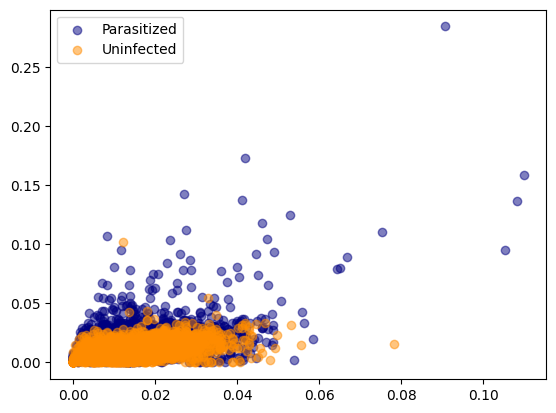

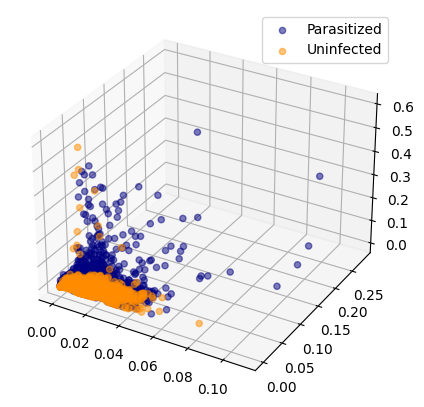

In [ ]:


parasitized_histnorm_data = load_histnorm_data(parasitized_dir)
uninfected_histnorm_data = load_histnorm_data(uninfected_dir)
plot_data_scatter(parasitized_histnorm_data, uninfected_histnorm_data)



**Creating and Loading Training and Testing Data**

Now that we have functionality to preprocess the malaria dataset and extract normalized colour histograms, we can write the functionality to split the data into a training set and a testing set. The load_datasets function takes care of loading the training and testing data from files if present. If not, it calls the appropriate functions to load the normalized colour histogram data, split into training and testing sets and save the relevant files to disk. The functions also ensure that splitting is done randomly and that classes are balanced in both training and testing datasets.

In [ ]:
def _add_class(data, positive_class=False):
    if positive_class:
        new_data = np.ones((data.shape[0], data.shape[1]+1))
    else:
        new_data = np.zeros((data.shape[0], data.shape[1]+1))
    new_data[:,:-1] = data[:,:]
    return new_data

def _create_training_testing_split(parasitized_class_data, uninfected_class_data, training=0.8):
    '''
        training: default to 80% of data
        testing: remaining data
    '''

    # equal count of parasitized and uninfected records in the malaria dataset
    assert parasitized_class_data.shape[0] == uninfected_class_data.shape[0]

    num_samples_in_each_class = parasitized_class_data.shape[0]
    num_features_plus_class = parasitized_class_data.shape[1]

    print('{0} samples in each class with {1} features.'.format(num_samples_in_each_class,
                                                                num_features_plus_class-1))

    training_count = floor(num_samples_in_each_class * training)
    testing_count = num_samples_in_each_class - training_count

    print('Splitting into {0} training and {1} testing samples.'.format(training_count,
                                                                        testing_count))

    # Create random training / testing index masks for parasitized / uninfected data
    # so as to split data randomly into training and testing sets.
    parasitized_testing_indices = random.sample(range(0, num_samples_in_each_class), testing_count)
    parasitized_training_mask = np.ones(num_samples_in_each_class, dtype=bool)
    parasitized_training_mask[parasitized_testing_indices] = False
    uninfected_testing_indices = random.sample(range(0, num_samples_in_each_class), testing_count)
    uninfected_training_mask = np.ones(num_samples_in_each_class, dtype=bool)
    uninfected_training_mask[uninfected_testing_indices] = False

    # creating training data set
    training_data = np.zeros((training_count*2, num_features_plus_class))
    training_data[:training_count,:] = parasitized_class_data[parasitized_training_mask]
    training_data[training_count:,:] = uninfected_class_data[uninfected_training_mask]

    testing_data = np.zeros((testing_count*2, num_features_plus_class))
    testing_data[:testing_count,:] = parasitized_class_data[~parasitized_training_mask]
    testing_data[testing_count:,:] = uninfected_class_data[~uninfected_training_mask]

    # shuffle rows
    np.random.shuffle(training_data)
    np.random.shuffle(testing_data)

    return training_data, testing_data

def _create_training_testing_data():
    print('Creating training and testing data files...')

    print('Loading histnormed data...')
    parasitized_histnorm_data = load_histnorm_data(parasitized_dir)
    uninfected_histnorm_data = load_histnorm_data(uninfected_dir)

    print('Extracting features from data...')
    parasitized_class_data = _add_class(parasitized_histnorm_data, positive_class=True)
    uninfected_class_data = _add_class(uninfected_histnorm_data)

    print('Splitting data into training and testing data sets...')
    training_data, testing_data = _create_training_testing_split(parasitized_class_data,
                                                                 uninfected_class_data)

    assert np.sum(training_data[:,-1:]) == len(training_data)/2, "Training data is not balanced."
    assert np.sum(testing_data[:,-1:]) == len(testing_data)/2, "Testing data is not balanced."

    print('Done.')

    return training_data, testing_data

def load_datasets():
    training_file_path = path.join(malaria_dataset_path, ''.join(['training', default_ext]))
    testing_file_path = path.join(malaria_dataset_path, ''.join(['testing', default_ext]))

    if path.isfile(training_file_path) and path.isfile(testing_file_path):
        print('Loading training and testing data...')
        training_data = load_data(training_file_path)
        testing_data = load_data(testing_file_path)
        print('Done.')
    else:
        training_data, testing_data = _create_training_testing_data()

        print('Saving training and testing data sets...')
        training_data = save_data(training_data, training_file_path)
        testing_data = save_data(testing_data, testing_file_path)
        print('Done.')

    X_train = training_data[:,:-1]
    y_train = training_data[:,-1:]
    y_train = y_train.reshape([y_train.shape[0],])
    X_test = testing_data[:,:-1]
    y_test = testing_data[:,-1:]
    y_test = y_test.reshape([y_test.shape[0],])

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_datasets()



Creating training and testing data files...
Loading histnormed data...
Loading Parasitized...
Loading histnorm data...
Loading Uninfected...
Loading histnorm data...
Extracting features from data...
Splitting data into training and testing data sets...
13779 samples in each class with 10 features.
Splitting into 11023 training and 2756 testing samples.
Done.
Saving training and testing data sets...
Saving file /content/cell_images/training.npy...
Done.
Saving file /content/cell_images/testing.npy...
Done.
Done.


**Hyperparameter Tuning an SVM Model**

We will now use a grid search to fit multiple SVM models on the training data to determine the best gamma and C (cost) hyperparameters for an RBF kernel. Instead of a validation set we are going to use cross validation, which will be stratified to ensure a balanced dataset within each fold.

Also, before we fit each model we are going to preprocess the training data to standardize it and transform it using its principal componenets. For this reason we need to use a pipeline.

Loading training and testing data...
Done.


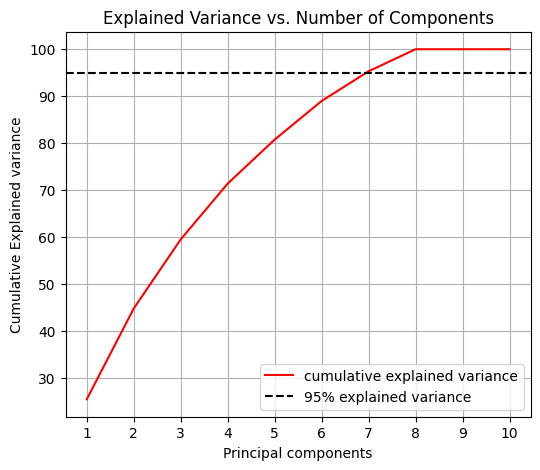

In [ ]:
X_train, y_train, X_test, y_test = load_datasets()
scaler = StandardScaler()
scaler.fit(X_train)
X_train_stand = scaler.transform(X_train)

pca = PCA()
pca.fit(X_train_stand)
cum_exp_var = pca.explained_variance_ratio_.cumsum()*100
d = [n for n in range(1, len(cum_exp_var)+1)]
plt.figure(figsize=(6, 5))
plt.xticks(d)
plt.grid(True, which='both')
plt.plot(d, cum_exp_var, color = 'red',label='cumulative explained variance')
plt.title('Explained Variance vs. Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% explained variance')
plt.legend(loc='best')
plt.show()

**Creating a Pipeline to Run a Grid Search**

We now create a pipeline so that on each fold we standardize the data and transform it using PCA. The PCA transformation will be limited to 7 principal components since these explain 95% of the variance.

In [ ]:


def perform_grid_search(C_range, gamma_range):
    X_train, y_train, X_test, y_test = load_datasets()

    scaler = StandardScaler()
    pca = PCA(n_components=7)
    svc = svm.SVC()
    pipe = Pipeline([('scaler',scaler),
                     ('pca',pca),
                     ('svc',svc)])

    param_grid = {'svc__C': C_range,
                  'svc__gamma': gamma_range}

    search = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=5), n_jobs=-1, verbose=2)
    search.fit(X_train, y_train)

    return search



In [ ]:


C_range = 10. ** np.arange(-1, 3)
gamma_range = 10. ** np.arange(-1, 3)

search = perform_grid_search(C_range, gamma_range)



Loading training and testing data...
Done.
Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [ ]:
green = (0.2, 0.8, 0.2)
yellow = (1, 1, 0)
red = (0.8, 0.2, 0.2)
from matplotlib.colors import ListedColormap

my_cmap = ListedColormap([green, yellow, red])

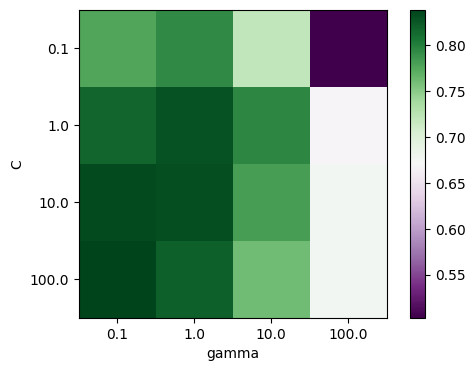

Best accuracy 0.838 using params: {'svc__C': 100.0, 'svc__gamma': 0.1}
Accuracy 95% confidence interval: 0.826 - 0.850


In [ ]:
scores = search.cv_results_['mean_test_score'].reshape(len(C_range), len(gamma_range))
plt.figure(figsize=(6, 4))

plt.imshow(scores, cmap=plt.cm.PRGn)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range)
plt.yticks(np.arange(len(C_range)), C_range)
plt.show()
print('Best accuracy {0:.3f} using params: {1}'.format(search.best_score_, search.best_params_))
best_accuracy_std = search.cv_results_['std_test_score'][search.best_index_]
print('Accuracy 95% confidence interval: {0:.3f} - {1:.3f}'.format(search.best_score_ - (best_accuracy_std*2),
                                                           search.best_score_ + (best_accuracy_std*2)))


**Fitting Final Model and Evaluating on Testing Set**

The final step is to evaluate the SVM model with RBF kernel and hyperparameters set to gamma=1 and C=100 on the testing set to get an estimate of the performance on unseen data.

In [ ]:


X_train, y_train, X_test, y_test = load_datasets()

scaler = StandardScaler()
scaler.fit(X_train)
X_train_stand = scaler.transform(X_train)
X_test_stand = scaler.transform(X_test)

pca = PCA(n_components=7)
pca.fit(X_train_stand)
pca_X_train = pca.transform(X_train_stand)
pca_X_test = pca.transform(X_test_stand)

clf = svm.SVC(kernel='rbf', gamma=1, C=100)
clf.fit(pca_X_train, y_train)



Loading training and testing data...
Done.


SVC(C=100, gamma=1)

In [ ]:
predictions = clf.predict(pca_X_test)

Accuracy: 0.832
Matthews CC: 0.665
F1 Score: 0.830
Sensitivity: 0.817
Specificity: 0.843


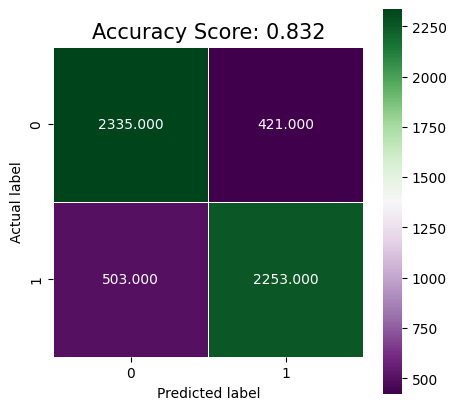

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
TP, FP, FN, TN = confusion_matrix.ravel()

specificity = TN / (TN + FP) # True Negative Rate

plt.figure(figsize=(5,5))
# my_colors = [(0.2, 0.8, 0.2), (1, 1, 0), (0.8, 0.2, 0.2)]
# reverse_cmap = my_colors[::-1]
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = plt.cm.PRGn)
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.3f}'.format(metrics.accuracy_score(y_test, predictions))
plt.title(all_sample_title, size = 15);

print('Accuracy: {0:.3f}'.format(metrics.accuracy_score(y_test, predictions)))
print('Matthews CC: {0:.3f}'.format(metrics.matthews_corrcoef(y_test, predictions)))
print('F1 Score: {0:.3f}'.format(metrics.f1_score(y_test, predictions)))
print('Sensitivity: {0:.3f}'.format(metrics.recall_score(y_test, predictions)))
print('Specificity: {0:.3f}'.format(specificity))



In [ ]:
import joblib# Save the model to a joblib file
filename = 'svm_model.joblib'
joblib.dump(clf, filename)

['svm_model.joblib']

In [ ]:
from joblib import dump, load
if os.path.exists('svm_model.joblib'):
    svm_model = load('svm_model.joblib')


In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.82      0.85      0.83      2756
         1.0       0.84      0.82      0.83      2756

    accuracy                           0.83      5512
   macro avg       0.83      0.83      0.83      5512
weighted avg       0.83      0.83      0.83      5512



In [ ]:
svm_results = svm_model.predict(pca_X_test)
print(f"Accuracy: {accuracy_score(y_test, svm_results)}")
print(f"Recall: {recall_score(y_test, svm_results)}")

Accuracy: 0.8323657474600871
Recall: 0.8174891146589259


**recommendation**